# A Playground Notebook for visualization of Neural Networks in sklearn

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import load_digits

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import _base
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from tqdm import tqdm_notebook
import itertools
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

# 1. Dataset 1 -  Digits:

In [5]:
d = load_digits()
X = d['data']
y = d['target']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=2)

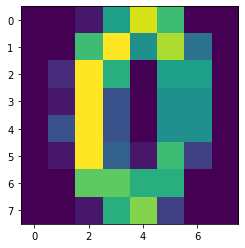

In [212]:
plt.imshow(X[10,:].reshape(8,8))
plt.show()

## Define potential Layer Sizes for a wide variety of MLP architectures:

In [ ]:
layer_sizes = [64, 128, 256]

### Get all permutations of Layers

In [ ]:
archs = []
for i in range(1, 6):
    archs.extend([p for p in itertools.product(layer_sizes, repeat=i)])
print(len(archs))
archs

## Training and Result-saving in DataFrame

In [ ]:
df = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Model'], index=archs)
df.head()

In [ ]:
for arch in tqdm_notebook(archs):
    model = MLPClassifier(hidden_layer_sizes=arch, verbose=False, max_iter=500, activation='relu', solver='adam')
    model.fit(X_train, y_train)
    df.loc[arch, 'Train Accuracy'] = accuracy_score(model.predict(X_train), y_train)
    df.loc[arch, 'Test Accuracy'] = accuracy_score(model.predict(X_test), y_test)
    df.loc[arch, 'Model'] = model

### Sort Results and Plot

In [ ]:
df.sort_values('Test Accuracy', ascending=False, inplace=True)

In [ ]:
results = df.head(20)

In [ ]:
_, ax = plt.subplots(figsize=(6,8))
results.iloc[::-1].plot.barh(ax=ax, color=['darkblue', 'lightgreen'])
ax.axvline(x=results['Test Accuracy'].max(), ymin = 0, ymax = 1, linewidth = 1, color = 'black', linestyle = ':')
ax.text(x=results['Test Accuracy'].max()-.2, y=-.9, s='Test-Acc: {:.4f}'.format(results['Test Accuracy'].max()))
ax.legend(loc='best', bbox_to_anchor=(1, 1))

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.facecolor':'darkgrey'})
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(results)//4):
    loss_curve = results['Model'].iloc[i].loss_curve_
    ax.plot(loss_curve, label=results['Model'].iloc[i].hidden_layer_sizes)
    ax.set(ylabel='Loss', xlabel='Epochs')
ax.legend()

## Get Feature Maps:

### Get Best Model:

In [ ]:
model = results['Model'].iloc[0]

## Util Functions:

In [213]:
def is_perfect_square(n):
    x = n // 2
    y = set([x])
    while x * x != n:
        x = (x + (n // x)) // 2
        if x in y: 
            return False, x
        y.add(x)
    return True, x

In [230]:
def feedforward(image, y_true, model):

    activation_func = eval('_base.'+model.activation)
    output_act_func = eval('_base.'+model.out_activation_)
    
    input_img = image
    _, ax1 = plt.subplots(figsize=(16,4))
    ax1.imshow(input_img.reshape(8, 8))
    ax1.axis('off')
    
    y_hat = model.predict(input_img.reshape(1,-1))
    
    n_hidden_layers = len(model.hidden_layer_sizes)
        
    outs = []
    outs.append(activation_func(np.matmul(input_img, model.coefs_[0]) + model.intercepts_[0]))
    for i in range(1, n_hidden_layers):            
        outs.append(activation_func(np.matmul(outs[i-1], model.coefs_[i]) + model.intercepts_[i]))
    outs.append(output_act_func((np.matmul(outs[-1], model.coefs_[-1]) + model.intercepts_[-1]).reshape(1,-1)))

    fig, ax = plt.subplots(figsize=(16,4), ncols=len(outs))

    for i, out in enumerate(outs):
        N = out
        siz = np.sqrt(N.shape[0])

        if i==(len(outs)-1):
            ax[-1].imshow(N.reshape(1, 10))
        else:
            answer, val = is_perfect_square(N.size)
            if answer:
                ax[i].imshow(N.reshape(val, val))
            else:
                M = N.copy()
                M.resize(val,val+1)
                ax[i].imshow(M, resample=True)
            ax[i].set(xticks=[], yticks=[], title='Output Hidden Layer {}'.format(i+1))
            
    ax[-1].set(title='Output Layer\ny_Pred = {}, y_TRUE = {}'.format(y_hat, y_true), yticks=[],
              xticks=[i for i in range(10)])

### Define a custom Neural Network
Visualization works best with quadratic hidden layer sizes (e.g. [16, 64, 256]); There won't be any lines, edges, shapes in the visualization, because the architecture is a fully-connected network, without any convolutional layers 

In [231]:
# Uncomment if custom NN desired:
custom_arch = (256, 256, 256)
model = MLPClassifier(hidden_layer_sizes=custom_arch, verbose=False, max_iter=500, activation='relu', solver='adam')
model.fit(X_train, y_train)
print('Train ACC: {:.4f}'.format(accuracy_score(model.predict(X_train), y_train)))
print('Test ACC: {:.4f}'.format(accuracy_score(model.predict(X_test), y_test)))

Train ACC: 1.0000
Test ACC: 0.9531


### Any Prediciton Example:

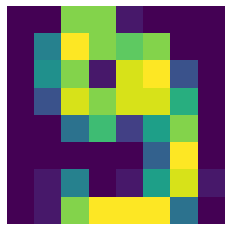

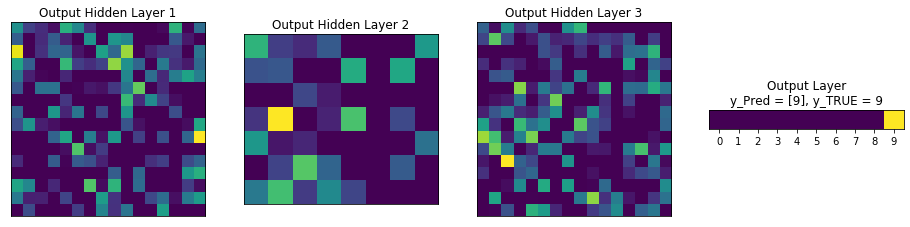

In [232]:
sample = random.choice([i for i in range(len(X))])
feedforward(X[sample], y[sample], model)

### Wrong Prediciton Example:

In [233]:
y_hat = model.predict(X_test)
mask = y_hat == y_test
mask = mask.tolist();

In [234]:
false_indices = []
for i, pred in enumerate(mask):
    if not pred:
        false_indices.append(i)

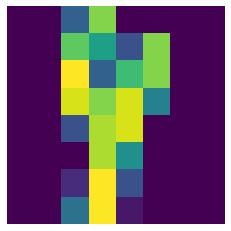

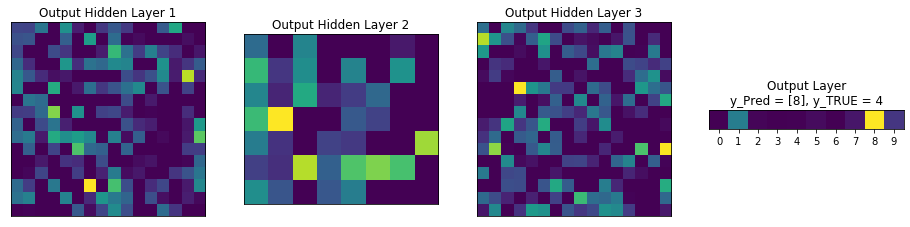

In [235]:
sample = random.choice(false_indices) # [0 ... 1796]
feedforward(X_test[sample], y_test[sample], model)

# 2. Another Dataset from sklearn

## Utils Functions:

In [2]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow', scattersize=3):
    plt.figure(figsize=(12,12));
    ax = ax or plt.gca();
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=scattersize, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3);
    ax.axis('tight');
    ax.axis('off');
    xlim = ax.get_xlim();
    ylim = ax.get_ylim();
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200));
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape);

    # Create a color plot with the results
    n_classes = len(np.unique(y));
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1);

    ax.set(xlim=xlim, ylim=ylim, aspect='equal');

In [3]:
def plot_MLP_Layers(model, X, y, figsize='auto', xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), cmap='coolwarm', title='on',
                    scattersizes=3):
    """
    INPUT: 
        model:        a sklearn.neural_networks.MLPClassifier model
        X:            Features
        y:            Labels
        figsize:      e.g (16, 16); default='auto'
        xlim:         x-axis-limits; default=(-1.5, 1.5)
        ylim:         y-axis-limits; default=(-1.5, 1.5)
        cmap:         matplotlib-colormap; default='coolwarm'
        title:        shows title (#Layer, #Node) of every subplot; default='on'; options= 'on', 'off'
        scattersizes: determines the size of the points in the scatterplots.
    OUTPUT:
        Plots Feature Maps of every node in a MLP.
    """
    # Grab number of hidden layers and set automated figure size:
    n_hidden_layers = len(model.hidden_layer_sizes)
    if figsize == 'auto':
        figsize = (n_hidden_layers*4, int(max(model.hidden_layer_sizes)*2))

    fig, ax = plt.subplots(figsize=figsize, nrows=max(model.hidden_layer_sizes), ncols=n_hidden_layers+1);
    
    # Grab Activation Functions:
    activation_func = eval('_base.'+model.activation)
    output_act_func = eval('_base.'+model.out_activation_)

    # Initialize mesh for decision boundarys of MLP:
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200));
    input_mesh = np.c_[xx.ravel(), yy.ravel()]

    # Feedforward Input:
    outs = []
    outs.append(activation_func(np.matmul(input_mesh, model.coefs_[0]) + model.intercepts_[0]))
    for i in range(1, n_hidden_layers):
        outs.append(activation_func(np.matmul(outs[-1], model.coefs_[i]) + model.intercepts_[i]))
    outs.append((np.matmul(outs[-1], model.coefs_[-1]) + model.intercepts_[-1]))

    # Plot Outputs of every node in every layer:
    n_classes = len(np.unique(y));
    for layer in range(len(model.hidden_layer_sizes)):
        for node in range(model.hidden_layer_sizes[layer]):
            # Plot the training points
            ax[node][layer].scatter(X[:, 0], X[:, 1], c=y, s=scattersizes, cmap=cmap,
                       clim=(y.min(), y.max()), zorder=0);
            ax[node][layer].axis('off');
            ax[node][layer].axis('tight');

            contours = ax[node][layer].contourf(xx, yy, output_act_func(outs[layer][:,node]).reshape(xx.shape), alpha=0.3,
                                   levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, clim=(y.min(), y.max()), zorder=2);
            ax[node][layer].set(aspect='equal')
            if title == 'on':
                ax[node][layer].set_title('L{}, Node{}'.format(layer+1, node+1))
            else:
                ax[0][layer].set_title('Layer {}'.format(layer+1))
    ax[0][-1].set(aspect='equal', title='Output')
    visualize_classifier(model, X, y, ax=ax[0][-1], cmap='coolwarm', scattersize=scattersizes)

    # Remove empty Axes-Objects:
    for i in range(n_hidden_layers+1):
        for j in range(max(model.hidden_layer_sizes)):
            if ax[j][i].has_data() == False:
                fig.delaxes(ax[j][i])

In [4]:
def make_spirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 1200 * (2*np.pi)/360
    d1x = -np.cos(n)*n + (np.random.rand(n_points,1) * noise)
    d1y = np.sin(n)*n + (np.random.rand(n_points,1) * noise)
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

## Dataset & Model

### Choose a Dataset:

- 'A' = 2 circles
- 'B' = 2 circular datasets
- 'C' = 2 half-moons
- 'D' = 2 spirals

Enable Polynomial Feature Extraction: (VISUALIZATION DOES NOT WORK YET)
- 'ON' : Activates Polynomial Feature Extraction
- 'OFF': Deactivates it

In [5]:
your_choice_datasets = 'D'
poly_feat_activation = 'OFF'

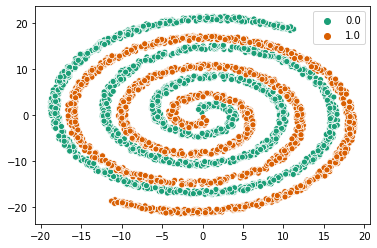

In [62]:
from sklearn.datasets import (make_circles, make_blobs, make_moons, make_swiss_roll)
N = 2000
options = {'A': make_circles(n_samples=N, factor=.6, noise=.1),
           'B': make_blobs(n_samples=N, centers=[[-1,-1],[1,1]], n_features=2, cluster_std=1),
           'C': make_moons(n_samples=N, noise=.18),
           'D': make_spirals(N, noise=1)}
Xs, ys = options[your_choice_datasets]
sns.scatterplot(x=Xs.T[0], y=Xs.T[1], hue=ys, palette='Dark2')

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, train_size=0.7)

In [7]:
if poly_feat_activation == 'ON':
    feature_generator = PolynomialFeatures(degree=3)
    X_train = feature_generator.fit_transform(X_train)
    X_test = feature_generator.fit_transform(X_test)

In [8]:
X_train.shape, X_test.shape

((2800, 2), (1200, 2))

### Define a MLP, train it, play with its hyperparameters and see results:

In [63]:
model = MLPClassifier(hidden_layer_sizes=(32, 32, 32, 16, 8),
                      verbose=False, 
                      max_iter=5000, 
                      activation='tanh', alpha=0,
                      solver='adam')
model.fit(X_train, y_train)
print('Train Accuracy: {:.4f}'.format(accuracy_score(model.predict(X_train), y_train)))
print('Test Accuracy: {:.4f}'.format(accuracy_score(model.predict(X_test), y_test)))

Train Accuracy: 0.9293
Test Accuracy: 0.9208


### Plot Stuff

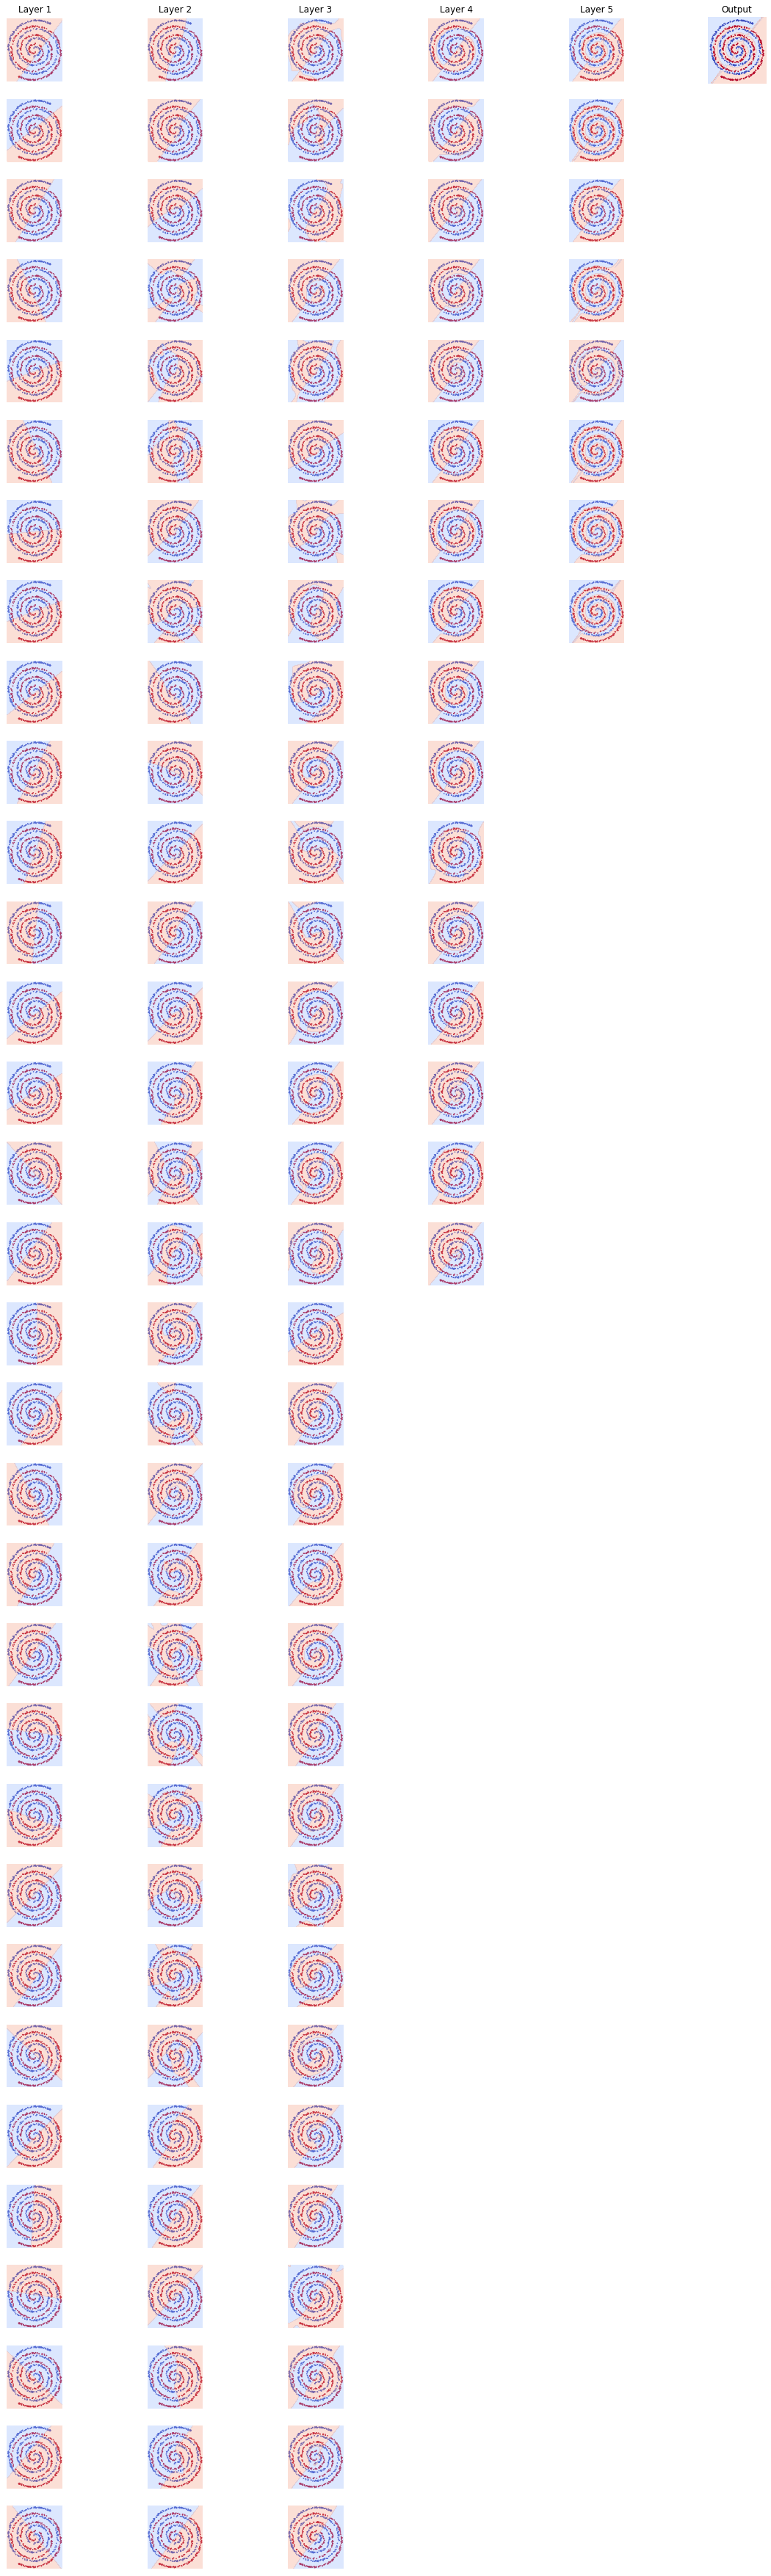

<Figure size 864x864 with 0 Axes>

In [64]:
plot_MLP_Layers(model, Xs[::5], ys[::5], figsize='auto', 
                xlim=(Xs[:,0].min()-.5, Xs[:,0].max()+.5),
                ylim=(Xs[:,1].min()-.5, Xs[:,1].max()+.5),
                cmap='coolwarm', title='off', scattersizes=.5)

### Testing other Classifier Models:

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
# model = GradientBoostingClassifier(n_estimators=1000)
model = SVC(kernel='rbf', C=.1, gamma='auto')
model.fit(X_train, y_train)

SVC(C=0.1, gamma='auto')

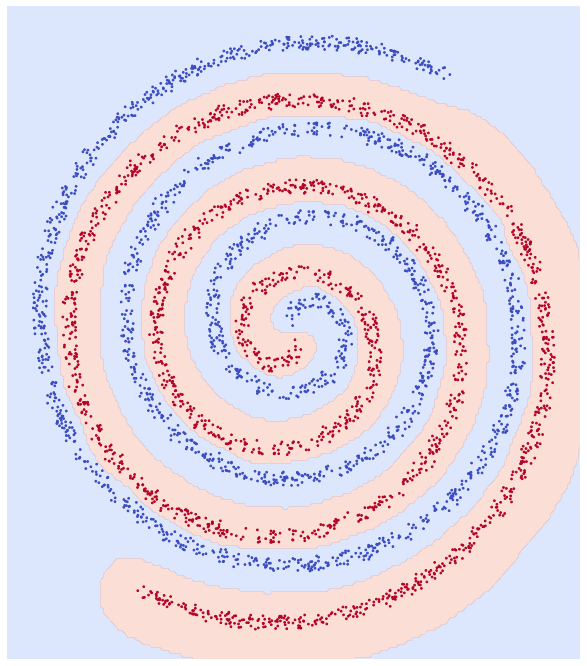

In [66]:
visualize_classifier(model, Xs, ys, ax=None, cmap='coolwarm')